# One-dimensional problems

We propose two different one-dimensional problems, that relax in:

1. Quasi-uniform state (uniform state with magnetisation tilting at the boundaries)
2. Helical state

The simulated material is FeGe with material parameters:

- $M_\text{s} = 384 \,\text{kA}\,\text{m}^{-1}$
- $A = 8.78 \,\text{pJ}\,\text{m}^{-1}$
- $D = 1.58 \,\text{mJ}\,\text{m}^{-2}$

## Quasi-ferromagnetic state

### Simulation
We simulate a $100 \,\text{nm}$ one dimensional sample with $(5 \,\text{nm}, 5 \,\text{nm}, 5 \,\text{nm})$ discretisation. More precisely, we relax the $(0, 0, 1)$ magnetisation configuration and add the uniaxial anisotropy term to the Hamiltonian with $K=0.51 \,\text{MJ}\,\text{m}^{-3}$ in the $u=(0, 0, 1)$ direction.

In [38]:
import oommfc as oc
import discretisedfield as df
import numpy as np
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

# Geometry parameters
L = 100e-9 # sample length (nm)
d = 5e-9  # discretisation (nm)

# Material parameters
Ms = 3.84e5  # magnetisation saturation (A/m)
A = 8.78e-12  # exchange energy constant (J/m)
D = 1.58e-3  # DMI energy constant (J/m**2)
K = 0.51e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis

# Define mesh
mesh = oc.Mesh(p1=(-L/2, 0, 0), p2=(L/2, d, d), cell=(d, d, d))

# Define system
system = oc.System(name="quasi-ferromagnetic")
system.hamiltonian = oc.Exchange(A=A) + oc.DMI(D=D, kind='bulk') + oc.UniaxialAnisotropy(K1=K, u=u)
system.m = df.Field(mesh, value=(0, 0, 1), norm=Ms)

md = oc.MinDriver()
md.drive(system)

2017/11/2 12:52: Calling OOMMF (quasi-ferromagnetic/quasi-ferromagnetic.mif) ... [0.9s]


/usr/local/lib/python3.5/dist-packages/oommfodt/oommfodt.py:114: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.units = dict(zip(columns, units))


After the system is relaxed, we can extract and plot the magnetisation components:

In [39]:
my_simulation = []
mz_simulation = []
x_simulation = []
for coord in mesh.coordinates:
    x_simulation.append(coord[0]/1e-9)
    my_simulation.append(system.m(coord)[1]/Ms)
    mz_simulation.append(system.m(coord)[2]/Ms)

### Analytic solution

The analytic solution for the quasi-ferromagnetic state can be obtained by solving the second-order boundary value problem defined as

$$\frac{d^{2}\theta}{dx^{2}} = \frac{\cos\theta\sin\theta}{\Delta^{2}}$$
$$\frac{d\theta}{dx} = -\frac{1}{\xi}$$

where $\Delta = \sqrt{A/K}$ and $\xi = 2A/D$. To solve it, we perform the shooting method.

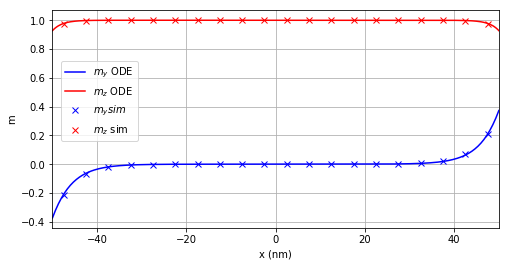

In [40]:
delta = np.sqrt(A/K)
xi = 2*A/D


def ode_1d(theta, x_array):
    return np.array([theta[1], np.cos(theta[0])*np.sin(theta[0])/delta**2])


def error(dtheta_guess):
    solution = scipy.integrate.odeint(ode_1d, np.array([np.arcsin(-delta/xi), dthetadr_guess/xi]), x_array) 
    return solution[-1,0] - np.arcsin(delta/xi)

x_array = np.linspace(-L/2, L/2, 300)

dtheta_guess_range = np.linspace(0.9, 1.1, 100)

errors = []
for dtheta_guess in dtheta_guess_range:
    errors.append(error(dtheta_guess))

# find the root of the residual function, i.e. the zero crossing, use the scipy.brentq method for this purpose
dtheta_0 = scipy.optimize.brentq(residual, 0.9, 1.1)

# plug the found solution for the missing boundary condition into the ODE solver
m_analytic = scipy.integrate.odeint(ode_1d, np.array([np.arcsin(-delta/xi), dtheta_0/xi]), x_array)

plt.figure(figsize=(8, 4))
# Analytic result
plt.plot(x_array/1e-9, np.sin(m_analytic[:, 0]), 'b', label=r'$m_y$ ODE')
plt.plot(x_array/1e-9, np.cos(m_analytic[:, 0]), 'r', label=r'$m_z$ ODE')
# Simulation result
plt.plot(x_simulation, my_simulation, 'bx', label=r'$m_y sim$')
plt.plot(x_simulation, mz_simulation, 'rx', label=r'$m_z$ sim')

plt.xlim([-L/2e-9, L/2e-9])
plt.xlabel('x (nm)')
plt.ylabel('m')
plt.legend(loc=(0.02,0.4))
plt.grid()

## Helix

2017/11/2 13:44: Calling OOMMF (helical/helical.mif) ... [3.2s]


/usr/local/lib/python3.5/dist-packages/oommfodt/oommfodt.py:114: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.units = dict(zip(columns, units))


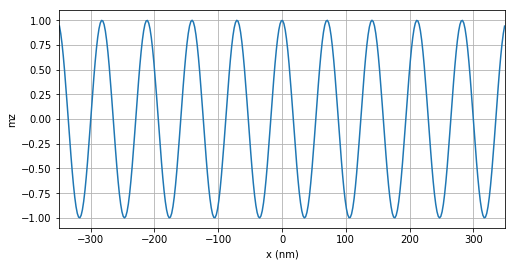

In [99]:
L = 700e-9 # sample length (nm)
d = 2e-9  # discretisation (nm)

mesh = oc.Mesh(p1=(-L/2, 0, 0), p2=(L/2, d, d), cell=(d, d, d))

system = oc.System(name="helical")
system.hamiltonian = oc.Exchange(A=8.78e-12) + oc.DMI(D=1.58e-3, kind='bulk')
system.m = df.Field(mesh, value=(0, 0, 1), norm=Ms)

md = oc.MinDriver()
md.drive(system)

x = []
mz = []
for coord in mesh.coordinates:
    x.append(coord[0]/1e-9)
    mz.append(system.m(coord)[2]/Ms)
    
plt.figure(figsize=(8, 4))
plt.plot(x, mz)
plt.xlabel("x (nm)")
plt.ylabel("mz")
plt.xlim([-L/2e-9, L/2e-9])
plt.grid()

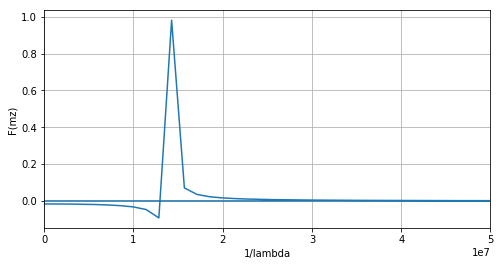

In [107]:
fourier = np.real(2*np.fft.fft(mz)/len(mz))
x_axis = np.fft.fftfreq(len(mz), d)

plt.figure(figsize=(8, 4))
plt.plot(x_axis, fourier)
plt.xlabel("1/lambda")
plt.ylabel("F(mz)")
plt.xlim([0, 0.5e8])
plt.grid()

Finally, we can find the peak

In [101]:
import operator
index, value = max(zip(x_axis, fourier), key=operator.itemgetter(1))

print("The peak of the Fourier transform corresponds to the helical period of {} nm.".format(1/index/1e-9))

The peak of the Fourier transform corresponds to the helical period of 70.0 nm.
